# Anomaly Detection of Housing Scam database

In [ ]:
pip install catboost

     |████████████████████████████████| 62.9MB 1.2MB/s 


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# Generate auth tokens for Colab
from google.colab import auth 
auth.authenticate_user()
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive
print ('Files in Drive:')
!ls drive/

In [ ]:
import pandas as pd 
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

from datetime import datetime 
from imblearn.over_sampling import SMOTE

# Data Import

In [ ]:
df = pd.read_csv("drive/HA_Data_Science_train.csv")
df_test = pd.read_csv("drive/HA_Data_Science_test.csv")

Take a look at the dataframe, this will show us what we are working with. As can be seen, the shape shows that there are 16762 rows with 15 columns. One of them is our target column 'IS_SCAMMER'

In [ ]:
print("Data Shape: {}".format(df.shape))
df.head()

Data Shape: (16762, 15)


,LISTING_KIND,LISTING_CITY,LISTING_PRICE,IS_ARCHIVED,ARCHIVE_REASON,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,IS_SCAMMER,ANONYMISED_EMAIL
0,1,Göteborg,725.00,False,NaN,se,se,0,80,False,1,Mobile Safari,iOS,0,bosqlqg@aol.com
1,1,Göteborg,469.35,False,NaN,se,se,1,70,False,1,Chrome,Android,0,fylm235670@gmail.com
2,1,Elche,200.00,False,NaN,es,es,0,25,False,0,Chrome,Android,0,mhzasjonfobc@gmail.com
3,0,Verona,1500.00,False,NaN,it,it,0,86,False,1,Chrome,Mac OS X,0,uclypkijb@italianflat.com
4,1,Copenhagen,904.16,False,NaN,dk,dk,0,5,False,1,Microsoft Edge,Windows,0,dyrrtatzx.fhcs@outlook.com


In [ ]:
print(df_test.shape)
df_test.head()

(1918, 12)


,LISTING_KIND,LISTING_CITY,LISTING_PRICE,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,ANONYMISED_EMAIL
0,1,Elche,155.00,es,es,0,35,False,1,Chrome,Android,drhzhephmeo@hotmail.com
1,1,Tilburg,420.00,nl,nl,1,40,False,1,Microsoft Edge,Windows,jorpr80ckig@gmail.com
2,1,Las Vegas,591.18,us,us,0,100,False,1,Mobile Safari,iOS,xaswrxawlgba@icloud.com
3,1,Utrecht,700.00,nl,nl,1,60,False,1,Firefox,Mac OS X,gnszyfo@universityhousing.nl
4,1,The Hague,600.00,fr,nl,1,54,False,1,Chrome,Windows,ttcjbtm@ziggo.nl


Since the target column is IS_SCAMMER, lets take a look its value counts


In [ ]:
df['IS_SCAMMER'].value_counts()

0    15792
1      970
Name: IS_SCAMMER, dtype: int64

As can be seen, there is a class imbalance. Only 970 rows are deemed as Scams. 


---
We removed the two columns to match the test set



In [ ]:
df.pop('IS_ARCHIVED')
df.pop('ARCHIVE_REASON')
df = df.fillna(0)

In [ ]:
df.shape

(16762, 13)




---


Now lets analyse and visualize the listing price distribution with respect to scam and non-scam data

To do this, lets create a new df with just LISTING_PRICE and IS_SCAMMER and then normalise the data.

In [ ]:
# create a new data_frame with just LISTING_PRICE and target column IS_SCAMMER
df_price = df[['LISTING_PRICE']]

df_price['IS_SCAMMER'] = df['IS_SCAMMER']

In [ ]:
df_price.head()

,LISTING_PRICE,IS_SCAMMER
0,725.00,0
1,469.35,0
2,200.00,0
3,1500.00,0
4,904.16,0


In [ ]:
numeric_attr_names = ['LISTING_PRICE']

# add a small epsilon to eliminate zero values from data for log scaling
# explain where you got this idea from and give credit
numeric_attr = df_price[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
df_visualise = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

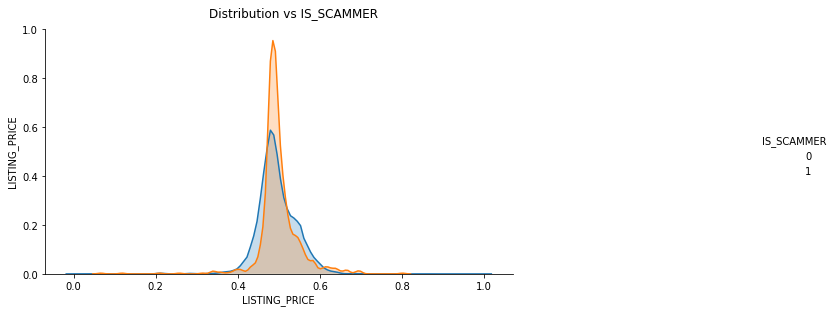

In [ ]:
# append 'label' attribute for colour distinction
df_visualise['IS_SCAMMER'] = df_price['IS_SCAMMER']

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=df_visualise, vars=numeric_attr_names, hue='IS_SCAMMER')
g.fig.suptitle('Distribution vs IS_SCAMMER')
g.fig.set_size_inches(15, 5)

As can be seen in the graph above, the scammed listing prices are a lot higher than non_scammed. So this is significant!


---


In [ ]:
# create a new data_frame with just ADVERTISER_SCORE and target column IS_SCAMMER
df_ad = df[['ADVERTISER_COMPLETENESS_SCORE']]

df_ad['IS_SCAMMER'] = df['IS_SCAMMER']
numeric_attr_names = ['ADVERTISER_COMPLETENESS_SCORE']

# add a small epsilon to eliminate zero values from data for log scaling
# explain where you got this idea from and give credit
numeric_attr = df_ad[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
df_visualise = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

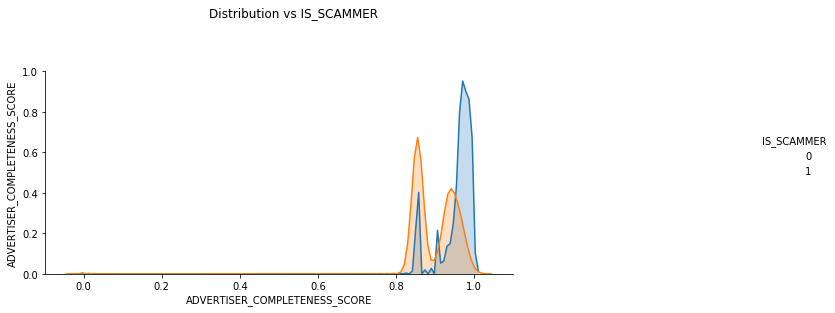

In [ ]:
# append 'label' attribute for colour distinction
df_visualise['IS_SCAMMER'] = df_ad['IS_SCAMMER']

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=df_visualise, vars=numeric_attr_names, hue='IS_SCAMMER')
g.fig.suptitle('Distribution vs IS_SCAMMER')
g.fig.set_size_inches(15, 5)

In [ ]:
df_MA = df[['MANAGED_ACCOUNT']]
df_MA['IS_SCAMMER'] = df['IS_SCAMMER']
df.MANAGED_ACCOUNT.value_counts()


False    16340
True       422
Name: MANAGED_ACCOUNT, dtype: int64

As noticed, most of the columns are pretty significant and will be used as features.
The only columns I left out as features are locations - Listing city and lisitng country code as I believe that scams can happen to anyone from any country. If the model is not good enough, we can also try with these columns as features

In [ ]:
X_train = df.copy()
X_train.pop('LISTING_COUNTRY_CODE')
X_train.pop('LISTING_CITY')
X_train.pop('ANONYMISED_EMAIL')
X_train.head()

,LISTING_KIND,LISTING_PRICE,LOGIN_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,IS_SCAMMER
0,1,725.00,se,0,80,False,1,Mobile Safari,iOS,0
1,1,469.35,se,1,70,False,1,Chrome,Android,0
2,1,200.00,es,0,25,False,0,Chrome,Android,0
3,0,1500.00,it,0,86,False,1,Chrome,Mac OS X,0
4,1,904.16,dk,0,5,False,1,Microsoft Edge,Windows,0


In [ ]:
X_train.dtypes

LISTING_KIND                       int64
LISTING_PRICE                    float64
LOGIN_COUNTRY_CODE                object
LISTING_REGISTRATION_POSSIBLE      int64
ADVERTISER_COMPLETENESS_SCORE      int64
MANAGED_ACCOUNT                     bool
HAS_PROFILE_PIC                    int64
BROWSER                           object
OS                                object
IS_SCAMMER                         int64
dtype: object

In [ ]:
X_test = df_test.copy()
X_test_numerical = X_test._get_numeric_data().drop(['MANAGED_ACCOUNT'], axis =1)

In [ ]:
X_train_numerical = X_train._get_numeric_data().drop(['MANAGED_ACCOUNT'], axis =1)


In [ ]:
X_train_numerical.head()

,LISTING_KIND,LISTING_PRICE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,HAS_PROFILE_PIC,IS_SCAMMER
0,1,725.00,0,80,1,0
1,1,469.35,1,70,1,0
2,1,200.00,0,25,0,0
3,0,1500.00,0,86,1,0
4,1,904.16,0,5,1,0


Now we have to normalise the numerical data and then substitute numerical values for categorical data such as IS_ARCHIVED, LOGIN_COUNTRY_CODE, etc
We will use Sklearn for this process.


---

Normalise using min-max-scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()


# normalise test set
X_test_numerical[['LISTING_KIND',
    'LISTING_PRICE',
    'LISTING_REGISTRATION_POSSIBLE',
    'ADVERTISER_COMPLETENESS_SCORE',
    'HAS_PROFILE_PIC' ]] = min_max_scaler.fit_transform(X_test_numerical[['LISTING_KIND',
                                                    'LISTING_PRICE',
                                                    'LISTING_REGISTRATION_POSSIBLE',
                                                    'ADVERTISER_COMPLETENESS_SCORE',
                                                    'HAS_PROFILE_PIC']])

In [ ]:

# normalise train set

X_train_numerical[['LISTING_KIND',
    'LISTING_PRICE',
    'LISTING_REGISTRATION_POSSIBLE',
    'ADVERTISER_COMPLETENESS_SCORE',
    'HAS_PROFILE_PIC' ]] = min_max_scaler.fit_transform(X_train_numerical[['LISTING_KIND',
                                                    'LISTING_PRICE',
                                                    'LISTING_REGISTRATION_POSSIBLE',
                                                    'ADVERTISER_COMPLETENESS_SCORE',
                                                    'HAS_PROFILE_PIC']])
X_train_numerical.head()

,LISTING_KIND,LISTING_PRICE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,HAS_PROFILE_PIC,IS_SCAMMER
0,0.5,0.000725,0.0,0.80,1.0,0
1,0.5,0.000469,1.0,0.70,1.0,0
2,0.5,0.000200,0.0,0.25,0.0,0
3,0.0,0.001500,0.0,0.86,1.0,0
4,0.5,0.000904,0.0,0.05,1.0,0


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X_train['LOGIN_COUNTRY_CODE']=X_train['LOGIN_COUNTRY_CODE'].astype(str)
X_train['BROWSER']=X_train['BROWSER'].astype(str)
X_train['OS']=X_train['OS'].astype(str)

X_train = X_train.select_dtypes([object,bool])

X_train = X_train.apply(LabelEncoder().fit_transform)



In [ ]:
# test set

X_test['LOGIN_COUNTRY_CODE']=X_test['LOGIN_COUNTRY_CODE'].astype(str)
X_test['BROWSER']=X_test['BROWSER'].astype(str)
X_test['OS']=X_test['OS'].astype(str)

X_test = X_test.select_dtypes([object,bool])

X_test = X_test.apply(LabelEncoder().fit_transform)

merge both normalized and categorical encoded data by index

In [ ]:
X_test = pd.merge(X_test_numerical, X_test, left_index=True, right_index=True)
X_test.head()

,LISTING_KIND,LISTING_PRICE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,HAS_PROFILE_PIC,LISTING_CITY,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,MANAGED_ACCOUNT,BROWSER,OS,ANONYMISED_EMAIL
0,0.5,0.000145,0.0,0.35,1.0,88,20,14,0,1,0,284
1,0.5,0.000410,1.0,0.40,1.0,263,49,38,0,7,4,746
2,0.5,0.000581,0.0,1.00,1.0,133,66,55,0,8,6,1735
3,0.5,0.000690,1.0,0.60,1.0,273,49,38,0,4,3,505
4,0.5,0.000590,1.0,0.54,1.0,261,23,38,0,1,4,1477


In [ ]:
X_train = pd.merge(X_train_numerical, X_train, left_index=True, right_index=True)
X_train.head()

,LISTING_KIND,LISTING_PRICE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,HAS_PROFILE_PIC,IS_SCAMMER,LOGIN_COUNTRY_CODE,MANAGED_ACCOUNT,BROWSER,OS
0,0.5,0.000725,0.0,0.80,1.0,0,97,0,11,8
1,0.5,0.000469,1.0,0.70,1.0,0,97,0,3,1
2,0.5,0.000200,0.0,0.25,0.0,0,36,0,3,1
3,0.0,0.001500,0.0,0.86,1.0,0,54,0,3,5
4,0.5,0.000904,0.0,0.05,1.0,0,30,0,10,6


In [ ]:
y_train = X_train.pop('IS_SCAMMER')

In [ ]:
X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.7, random_state=0)

Upsampling minority class using Smote EXPLAIN 

In [ ]:
# selecting features
features = list(X_train.columns.values)
features

['LISTING_KIND',
 'LISTING_PRICE',
 'LISTING_REGISTRATION_POSSIBLE',
 'ADVERTISER_COMPLETENESS_SCORE',
 'HAS_PROFILE_PIC',
 'LOGIN_COUNTRY_CODE',
 'MANAGED_ACCOUNT',
 'BROWSER',
 'OS']

In [ ]:
sm = SMOTE(random_state=42)
X_training, y_training = sm.fit_resample(X_training, y_training)

In [ ]:
X_training.shape

(9496, 9)

As seen in the new X_train shape, the size doubled where we upsampled the minority class (is scammer) to match the majority class (non scam)

Split train data into train and validation

We will use random forest because in comparison with other models tested below, it was giving out the best recall and f1-score while only slightly decreasing performance.

Moreover, as can be seen below, the test dataset has the target column missing.

In [ ]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_training , y_training)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_valid[features])


In [ ]:
target_names = ['Not Scammer', 'Scammer']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Scammer       0.97      0.98      0.97     11044
     Scammer       0.59      0.54      0.56       690

    accuracy                           0.95     11734
   macro avg       0.78      0.76      0.77     11734
weighted avg       0.95      0.95      0.95     11734



In [ ]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             
                             od_wait=100)

In [ ]:
clf.fit(X_training , y_training)


In [ ]:
y_pred = clf.predict(X_valid[features])


In [ ]:
target_names = ['Not Scammer', 'Scammer']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Scammer       0.97      0.97      0.97     11044
     Scammer       0.57      0.57      0.57       690

    accuracy                           0.95     11734
   macro avg       0.77      0.77      0.77     11734
weighted avg       0.95      0.95      0.95     11734



In [ ]:
from sklearn import svm
from sklearn.svm import SVC
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(X_training , y_training)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=500, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=500, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = clf.predict(X_valid[features])


In [ ]:
target_names = ['Not Scammer', 'Scammer']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Scammer       0.98      0.79      0.87     11044
     Scammer       0.17      0.70      0.27       690

    accuracy                           0.78     11734
   macro avg       0.57      0.74      0.57     11734
weighted avg       0.93      0.78      0.84     11734



In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500, random_state=0, solver='lbfgs',
                        multi_class='multinomial').fit(X_training , y_training)

In [ ]:
y_pred = clf.predict(X_valid[features])


In [ ]:
target_names = ['Not Scammer', 'Scammer']
print(classification_report(y_valid, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Scammer       0.98      0.80      0.88     11044
     Scammer       0.20      0.80      0.31       690

    accuracy                           0.80     11734
   macro avg       0.59      0.80      0.60     11734
weighted avg       0.94      0.80      0.85     11734



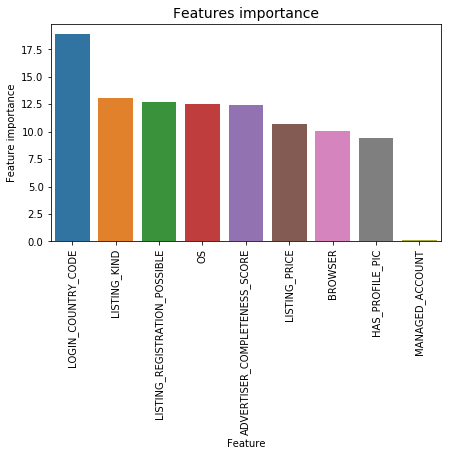

In [ ]:
tmp = pd.DataFrame({'Feature': features, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


# Test Prediction

In [ ]:
test_set_predictions = clf.predict(X_test[features])


In [ ]:
df_test['Prediction'] = test_set_predictions

In [ ]:
df_test.head(50)

,LISTING_KIND,LISTING_CITY,LISTING_PRICE,LOGIN_COUNTRY_CODE,LISTING_COUNTRY_CODE,LISTING_REGISTRATION_POSSIBLE,ADVERTISER_COMPLETENESS_SCORE,MANAGED_ACCOUNT,HAS_PROFILE_PIC,BROWSER,OS,ANONYMISED_EMAIL,Prediction
0,1,Elche,155.00,es,es,0,35,False,1,Chrome,Android,drhzhephmeo@hotmail.com,0
1,1,Tilburg,420.00,nl,nl,1,40,False,1,Microsoft Edge,Windows,jorpr80ckig@gmail.com,0
2,1,Las Vegas,591.18,us,us,0,100,False,1,Mobile Safari,iOS,xaswrxawlgba@icloud.com,0
3,1,Utrecht,700.00,nl,nl,1,60,False,1,Firefox,Mac OS X,gnszyfo@universityhousing.nl,0
4,1,The Hague,600.00,fr,nl,1,54,False,1,Chrome,Windows,ttcjbtm@ziggo.nl,0
5,2,Milan,450.00,it,it,1,70,False,1,Chrome,Linux,pblfqjl@yiton.it,0
6,1,Valencia,450.00,es,es,0,50,False,1,Chrome,Windows,joknrljztnocnneq@gmail.com,0
7,2,Berkeley,954.98,us,us,1,50,False,1,Chrome,Windows,gmy.ppkfvmqwhjoevqvnvuyeii@gmail.com,0
8,0,Salamanca,700.00,gr,es,0,40,False,1,NaN,NaN,p.n.oa.m.b.atevvtmz@gmail.com,0
9,0,Los Angeles,1364.26,us,us,1,45,False,1,Chrome,Mac OS X,groqrvpis.efnog@gmail.com,0


In [ ]:
df_test.Prediction.value_counts()


0    1759
1     159
Name: Prediction, dtype: int64